In [3]:
from pathos.multiprocessing import ProcessingPool
import numpy as np
import matplotlib.pyplot as plt

In [29]:
N_0 = 10
h = 0.016
m = 48
T = 1
L = 1

r_0 = np.random.uniform(-L/2, L/2, (N_0, 3)) #randomly between 0 and L with gaussian distribution, mean 0, std sqrt(kT^*/m^*), m^* = 48, k = 1, are the velocities normally distributed in every seperate direction?
v_0 = np.random.normal(0,np.sqrt(T/48), (N_0, 3))

"""
r_0: Initial positions of the system
    r_0[i]: 1D-array with 3 values, the coordinates of the i'th particle
v_0: Initial velocities of the system particles
    v_0[i]: 1D-array with 3 values, the velocity values of the i'th particle
"""

def f(r_i, r_j):
    r_ij = np.sqrt(np.sum([(r_i[d]-r_j[d])**2 for d in range(2)]))
    f_x = m*(r_i[0]-r_j[0])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_y = m*(r_i[1]-r_j[1])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_z = m*(r_i[2]-r_j[2])*(r_ij**(-14)+0.5*r_ij**(-8))
    return np.array([f_x, f_y, f_z])

def arange_without(i):
    original_array = np.arange(N_0)
    result_array = original_array[original_array != i]
    return result_array

def F(r):
    return np.array([np.sum(np.array([f(r[i], r[k]) for k in arange_without(i)]), axis=0) for i in range(r.shape[0])])

def verlet_step(r, v):
    v_tilde = v + h/(2*m)*F(r)
    r_next = r + h*v_tilde
    f_next = F(r_next)
    v_next = v_tilde + (h/(2*m))*f_next
    return r_next, v_next

def verlet_algorithm(r_0, v_0, num_steps):
    list_r = [r_0]
    list_v = [v_0]
    for t in range(num_steps):
        r_new, v_new = verlet_step(list_r[-1], list_v[-1])
        list_r.append(r_new)
        list_v.append(v_new)
    return np.array(list_r), np.array(list_v)

In [30]:
r_total, v_total = verlet_algorithm(r_0, v_0, 3)
r_total.shape

(4, 10, 3)

Text(0.5, 0.92, 'Initial state of the Argon ')

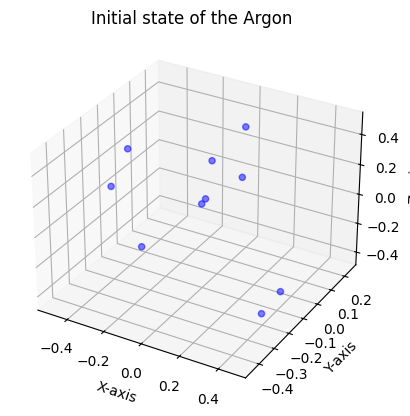

In [28]:
#Seeing how the initial state looks like
#ax = plt.figure().add_subplot(projection='3d')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, and z coordinates
x = r_0[:,0].flatten()
y = r_0[:,1].flatten()
z = r_0[:,2].flatten()

# Plot the points
ax.scatter(x, y, z, c='b', marker='o', alpha=0.5)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set the title
ax.set_title('Initial state of the Argon ')

# Show the plot
#plt.show()